In [1]:
import numpy as np
import pickle
from joblib import Parallel, delayed
from scipy import stats
from pyvbmc import VBMC
import corner
import matplotlib.pyplot as plt
from scipy.integrate import quad

from psiam_delay_paper_utils import abort_RT_loglike_fn, correct_RT_loglike_fn, wrong_RT_loglike_fn
from psiam_delay_paper_utils import rho_A_t_fn, cum_A_t_fn
from psiam_delay_paper_utils import rho_E_t_fn
from psiam_delay_paper_utils import rho_E_minus_small_t_NORM_fn
from psiam_delay_paper_utils import P_small_t_btn_x1_x2

In [2]:
with open('psiam_data_delay_paper_t_A_zero_t_motor_NEW_SIM_pos_vel_10_K.pkl', 'rb') as f:
    psiam_data = pickle.load(f)


choices = psiam_data['choices']
RTs = psiam_data['RTs']
is_act_resp = psiam_data['is_act_resp']
V_A = psiam_data['V_A']
theta_A = psiam_data['theta_A']
V_E = psiam_data['V_E']
theta_E = psiam_data['theta_E']
Z_E = psiam_data['Z_E']
t_stim = psiam_data['t_stim']
t_A_aff = psiam_data['t_A_aff']
t_E_aff = psiam_data['t_E_aff']
t_motor = psiam_data['t_motor']


indices_evid = np.where(is_act_resp == 0)[0]
RTs_evid = RTs[indices_evid].flatten()

indices_act = np.where(is_act_resp == 1)[0]
RTs_act = RTs[indices_act].flatten()

RTs = RTs.flatten()


correct_idx = np.where(choices == 1)[0]
wrong_idx = np.where(choices == -1)[0]
non_abort_idx = np.where(RTs >= t_stim)[0]

correct_non_abort_idx = np.intersect1d(correct_idx, non_abort_idx)
wrong_non_abort_idx = np.intersect1d(wrong_idx, non_abort_idx)

correct_RT = RTs[correct_non_abort_idx]
wrong_RT = RTs[wrong_non_abort_idx]

abort_idx = np.where(RTs < t_stim)[0]
abort_RT = RTs[abort_idx]


print(f"V_A: {V_A}")
print(f"theta_A: {theta_A}")
print(f"V_E: {V_E}")
print(f"theta_E: {theta_E}")
print(f"t stim is {t_stim}")
print(f"t_A_aff: {t_A_aff}, t_E_aff: {t_E_aff}, t_motor: {t_motor}")

print(f"Num of AI process: {is_act_resp.sum()}/{len(is_act_resp)}")
print(f'Number of aborts = {(RTs < t_stim).sum()}')

V_A: 1
theta_A: 2
V_E: 1.2
theta_E: 2
t stim is 0.5
t_A_aff: 0, t_E_aff: 0.03, t_motor: 0.1
Num of AI process: 5851/10000
Number of aborts = 87


In [3]:
def psiam_loglike_fn(params):
    V_A, theta_A, V_E, theta_E, Z_E, t_A_aff, t_E_aff, t_motor = params

    K_max = int(10)
    n_jobs = -1

    abort_loglike = sum(Parallel(n_jobs=n_jobs)(delayed(abort_RT_loglike_fn)(t, V_A, theta_A, V_E, theta_E, Z_E, K_max, t_A_aff, t_E_aff, t_stim, t_motor) for t in abort_RT))
    correct_loglike = sum(Parallel(n_jobs=n_jobs)(delayed(correct_RT_loglike_fn)(t, V_A, theta_A, V_E, theta_E, Z_E, K_max, t_A_aff, t_E_aff, t_stim, t_motor) for t in correct_RT))
    wrong_loglike = sum(Parallel(n_jobs=n_jobs)(delayed(wrong_RT_loglike_fn)(t, V_A, theta_A, V_E, theta_E, Z_E, K_max, t_A_aff, t_E_aff, t_stim, t_motor) for t in wrong_RT))


    loglike = abort_loglike + correct_loglike + wrong_loglike

    if np.isnan(loglike):
        raise ValueError('loglike is nan')
    if np.isinf(loglike):
        raise ValueError('loglike is inf')
    
    return loglike
    

In [4]:
#  V_A=1, theta_A=2, V_E=1.2, theta_E=2, Z_E=0, 
# t_A_aff=0.02, t_E_aff=0.03, t_motor=0.05

# 1, 1.2, 0 , 0.8
# 1, 2, 1.2, 2
V_A_bounds = [0.1, 2]; V_A_plausible_bounds = [0.5, 1.5]
theta_A_bounds = [1, 3]; theta_A_plausible_bounds = [1.5, 2.5]
V_E_bounds = [-2, 2]; V_E_plausible_bounds = [-1.5, 1.5]
theta_E_bounds = [0.1, 3]; theta_E_plausible_bounds = [0.5,2.5]
Z_E_bounds = [-0.5, 0.5]; Z_E_plausible_bounds = [-0.2, 0.2]

# V_A_bounds = [0.1, 5]; V_A_plausible_bounds = [0.5, 3]
# theta_A_bounds = [0.5, 5]; theta_A_plausible_bounds = [1, 3]
# V_E_bounds = [-5, 5]; V_E_plausible_bounds = [-3, 3]
# theta_E_bounds = [0.01, 5]; theta_E_plausible_bounds = [0.1, 4]
# Z_E_bounds = [-0.5, 0.5]; Z_E_plausible_bounds = [-0.3, 0.3]
# too close bounds:
# t_A_aff_bounds = [0.01, 0.06]; t_A_aff_plausible_bounds = [0.015, 0.05]
# t_E_aff_bounds = [0.01, 0.06]; t_E_aff_plausible_bounds = [0.02, 0.05]
# t_motor_bounds = [0.01, 0.06]; t_motor_plausible_bounds = [0.03, 0.06]

t_A_aff_bounds = [-0.01, 0.05]; t_A_aff_plausible_bounds = [-0.005, 0.03]
t_E_aff_bounds = [0.01, 0.06]; t_E_aff_plausible_bounds = [0.02, 0.05]
t_motor_bounds = [0, 0.2]; t_motor_plausible_bounds = [0.015, 0.15]


def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)

def psiam_log_prior_fn(params):
    V_A, theta_A, V_E, theta_E, Z_E, t_A_aff, t_E_aff, t_motor = params

    log_prior_V_A = trapezoidal_logpdf(V_A, V_A_bounds[0], V_A_plausible_bounds[0], V_A_plausible_bounds[1], V_A_bounds[1])
    log_prior_theta_A = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    log_prior_V_E = trapezoidal_logpdf(V_E, V_E_bounds[0], V_E_plausible_bounds[0], V_E_plausible_bounds[1], V_E_bounds[1])
    log_prior_theta_E = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], theta_E_plausible_bounds[1], theta_E_bounds[1])
    log_prior_Z_E = trapezoidal_logpdf(Z_E, Z_E_bounds[0], Z_E_plausible_bounds[0], Z_E_plausible_bounds[1], Z_E_bounds[1])
    log_prior_t_A_aff = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    log_prior_t_E_aff = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    log_prior_t_motor = trapezoidal_logpdf(t_motor, t_motor_bounds[0], t_motor_plausible_bounds[0], t_motor_plausible_bounds[1], t_motor_bounds[1])

    sum_log_priors = log_prior_V_A + log_prior_theta_A + log_prior_V_E + log_prior_theta_E + log_prior_Z_E + log_prior_t_A_aff + log_prior_t_E_aff + log_prior_t_motor
    return sum_log_priors
# def psiam_log_prior_fn(params):
#     V_A, theta_A, V_E, theta_E, Z_E, t_A_aff, t_E_aff, t_motor = params
    

#     # declare distributions
#     V_A_prior = stats.uniform(loc=V_A_bounds[0], scale=V_A_bounds[1] - V_A_bounds[0])
#     theta_A_prior = stats.uniform(loc=theta_A_bounds[0], scale=theta_A_bounds[1] - theta_A_bounds[0])
#     V_E_prior = stats.uniform(loc=V_E_bounds[0], scale=V_E_bounds[1] - V_E_bounds[0])
#     theta_E_prior = stats.uniform(loc=theta_E_bounds[0], scale=theta_E_bounds[1] - theta_E_bounds[0])
#     Z_E_prior = stats.uniform(loc=Z_E_bounds[0], scale=Z_E_bounds[1] - Z_E_bounds[0])
#     t_A_aff_prior = stats.uniform(loc=t_A_aff_bounds[0], scale=t_A_aff_bounds[1] - t_A_aff_bounds[0])
#     t_E_aff_prior = stats.uniform(loc=t_E_aff_bounds[0], scale=t_E_aff_bounds[1] - t_E_aff_bounds[0])
#     t_motor_prior = stats.uniform(loc=t_motor_bounds[0], scale=t_motor_bounds[1] - t_motor_bounds[0])


#     # PDF
#     log_prior_V_A = V_A_prior.logpdf(V_A)
#     log_prior_theta_A = theta_A_prior.logpdf(theta_A)
#     log_prior_V_E = V_E_prior.logpdf(V_E)
#     log_prior_theta_E = theta_E_prior.logpdf(theta_E)
#     log_prior_Z_E = Z_E_prior.logpdf(Z_E)
#     log_prior_t_A_aff = t_A_aff_prior.logpdf(t_A_aff)
#     log_prior_t_E_aff = t_E_aff_prior.logpdf(t_E_aff)
#     log_prior_t_motor = t_motor_prior.logpdf(t_motor)

#     sum_log_priors = log_prior_V_A + log_prior_theta_A + log_prior_V_E + log_prior_theta_E + log_prior_Z_E + log_prior_t_A_aff + log_prior_t_E_aff + log_prior_t_motor
#     return sum_log_priors

def log_joint(params):
    loglike = psiam_loglike_fn(params)
    logprior = psiam_log_prior_fn(params)
    prior_plus_loglike = loglike + logprior
    return prior_plus_loglike

In [5]:
lb = np.array([V_A_bounds[0], theta_A_bounds[0], V_E_bounds[0], theta_E_bounds[0], Z_E_bounds[0], 
               t_A_aff_bounds[0], t_E_aff_bounds[0], t_motor_bounds[0]])
ub = np.array([V_A_bounds[1], theta_A_bounds[1], V_E_bounds[1], theta_E_bounds[1], Z_E_bounds[1], 
               t_A_aff_bounds[1], t_E_aff_bounds[1], t_motor_bounds[1]])
plb = np.array([V_A_plausible_bounds[0], theta_A_plausible_bounds[0], V_E_plausible_bounds[0], theta_E_plausible_bounds[0], Z_E_plausible_bounds[0], 
                t_A_aff_plausible_bounds[0], t_E_aff_plausible_bounds[0], t_motor_plausible_bounds[0]])
pub = np.array([V_A_plausible_bounds[1], theta_A_plausible_bounds[1], V_E_plausible_bounds[1], theta_E_plausible_bounds[1], Z_E_plausible_bounds[1], 
                t_A_aff_plausible_bounds[1], t_E_aff_plausible_bounds[1], t_motor_plausible_bounds[1]])

np.random.seed(42)  
V_A_0 = np.random.uniform(plb[0], pub[0])
theta_A_0 =  np.random.uniform(plb[1], pub[1])
V_E_0 = np.random.uniform(plb[2], pub[2])
theta_E_0 = np.random.uniform(plb[3], pub[3])
Z_0 = np.random.uniform(plb[4], pub[4])
t_A_aff_0 = np.random.uniform(plb[5], pub[5])
t_E_aff_0 = np.random.uniform(plb[6], pub[6])
t_motor_0 = np.random.uniform(plb[7], pub[7])

x0 = np.array([V_A_0, theta_A_0, V_E_0, theta_E_0, Z_0, t_A_aff_0, t_E_aff_0, t_motor_0]);

vbmc = VBMC(log_joint, x0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 8).
Reshaping upper bounds to (1, 8).
Reshaping plausible lower bounds to (1, 8).
Reshaping plausible upper bounds to (1, 8).


/home/rka/.local/lib/python3.10/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/home/rka/.local/lib/python3.10/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/home/rka/.local/lib/python3.10/site-packages/cma/evolution_strategy.py:3823: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -12334.307 +/-0.036.


In [6]:
vp.save('VP_psiam_10K_t_A_zero_t_motor_large.pkl_17_09_POS_velocity_NEW_SIM.pkl')

In [2]:
# with open('VP_psiam_10K_t_A_zero_t_motor_large.pkl_17_09_negative_velocity.pkl', 'rb') as f:
#     vp = pickle.load(f)

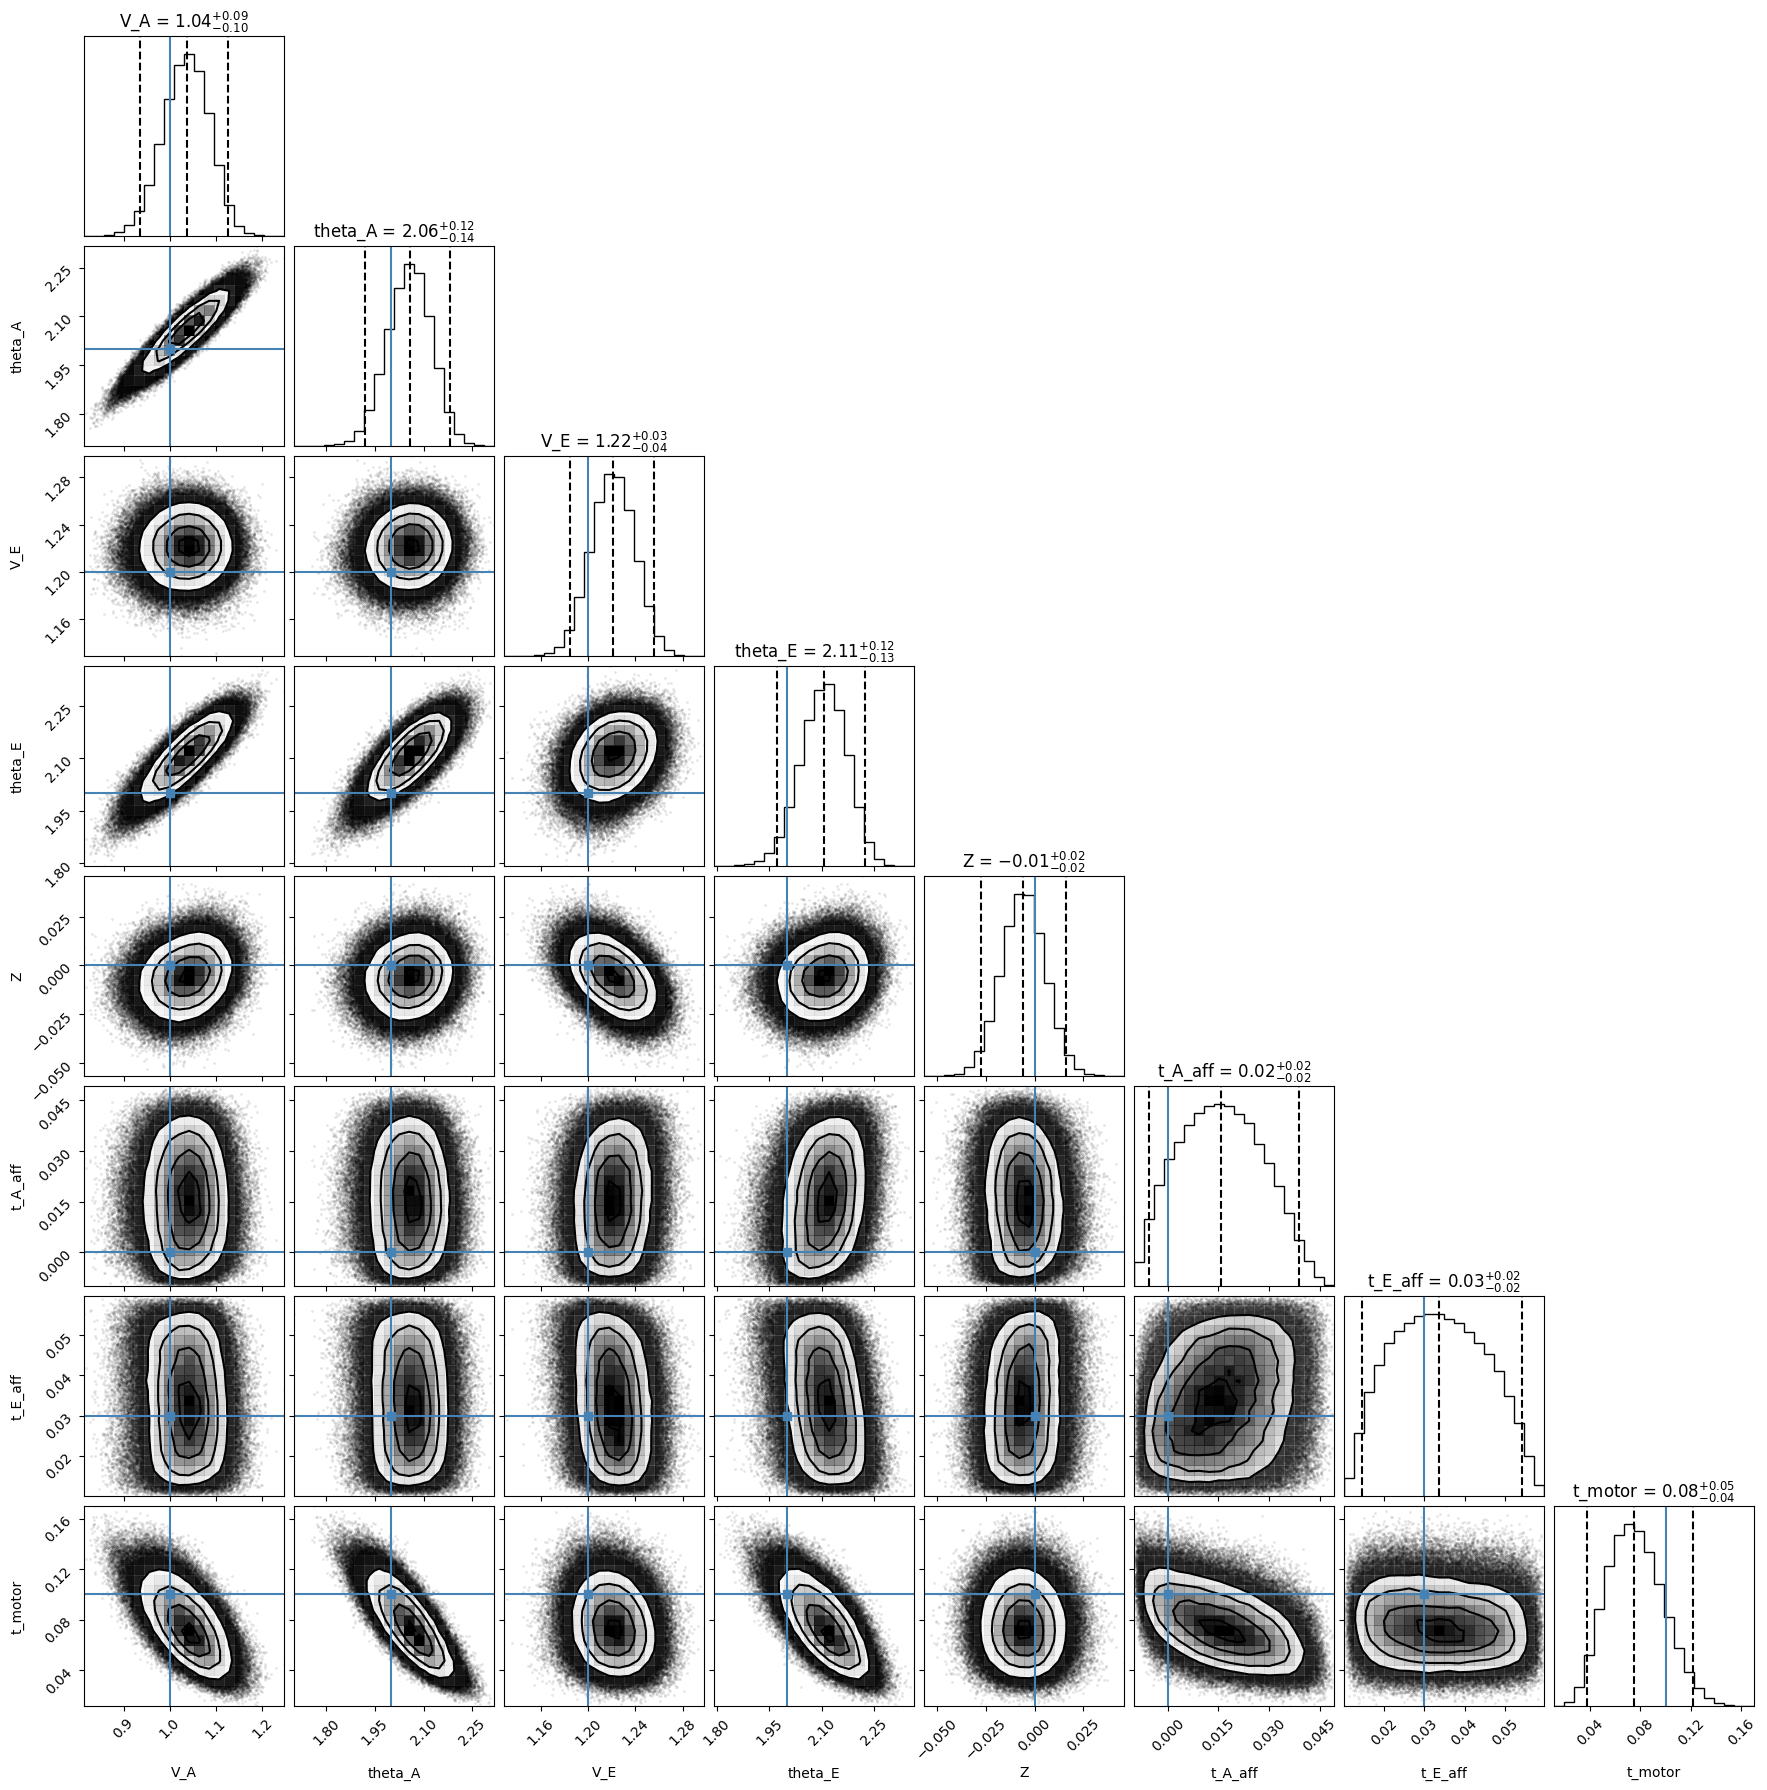

In [7]:
vp_samples = vp.sample(int(3e5))[0]
V_A_samp = vp_samples[:,0]; theta_A_samp = vp_samples[:,1]
V_E_samp = vp_samples[:,2]; theta_E_samp = vp_samples[:,3]
Z_samp =  vp_samples[:,4]
t_A_aff_samp = vp_samples[:,5]; t_E_aff_samp = vp_samples[:,6]; t_motor_samp = vp_samples[:,7]

combined_samples_vb = np.transpose(np.vstack((V_A_samp, theta_A_samp, V_E_samp, theta_E_samp, Z_samp, t_A_aff_samp, t_E_aff_samp, t_motor_samp)))
params_labels = ['V_A', 'theta_A', 'V_E', 'theta_E', 'Z', 't_A_aff', 't_E_aff', 't_motor']
true_arr = [V_A, theta_A, V_E, theta_E, Z_E, t_A_aff, t_E_aff, t_motor]

corner.corner(combined_samples_vb, labels=params_labels, show_titles=True, quantiles=[0.025, 0.5, 0.975], truths=true_arr); # range=corner_span


# Fitting with VBMC params

In [8]:
vbmc_mean_params = {}
vbmc_mean_params['V_A'] = np.mean(V_A_samp)
vbmc_mean_params['theta_A'] = np.mean(theta_A_samp)
vbmc_mean_params['V_E'] = np.mean(V_E_samp)
vbmc_mean_params['theta_E'] = np.mean(theta_E_samp)
vbmc_mean_params['Z_E'] = np.mean(Z_samp)
vbmc_mean_params['t_A_aff'] = np.mean(t_A_aff_samp)
vbmc_mean_params['t_E_aff'] = np.mean(t_E_aff_samp)
vbmc_mean_params['t_motor'] = np.mean(t_motor_samp)

vbmc_median_params = {}
vbmc_median_params['V_A'] = np.median(V_A_samp)
vbmc_median_params['theta_A'] = np.median(theta_A_samp)
vbmc_median_params['V_E'] = np.median(V_E_samp)
vbmc_median_params['theta_E'] = np.median(theta_E_samp)
vbmc_median_params['Z_E'] = np.median(Z_samp)
vbmc_median_params['t_A_aff'] = np.median(t_A_aff_samp)
vbmc_median_params['t_E_aff'] = np.median(t_E_aff_samp)
vbmc_median_params['t_motor'] = np.median(t_motor_samp)

# Fit 1M data pts, ground truth

In [9]:
with open('psiam_data_delay_paper_t_A_zero_t_motor_NEW_SIM_pos_vel_1Million.pkl', 'rb') as f:
    psiam_data = pickle.load(f)


choices = psiam_data['choices']
RTs = psiam_data['RTs']
is_act_resp = psiam_data['is_act_resp']
V_A = psiam_data['V_A']
theta_A = psiam_data['theta_A']
V_E = psiam_data['V_E']
theta_E = psiam_data['theta_E']
Z_E = psiam_data['Z_E']
t_stim = psiam_data['t_stim']
t_A_aff = psiam_data['t_A_aff']
t_E_aff = psiam_data['t_E_aff']
t_motor = psiam_data['t_motor']


indices_evid = np.where(is_act_resp == 0)[0]
RTs_evid = RTs[indices_evid].flatten()

indices_act = np.where(is_act_resp == 1)[0]
RTs_act = RTs[indices_act].flatten()

RTs = RTs.flatten()


choice_up_idx = np.where(choices == 1)[0]
RTs_up = RTs[choice_up_idx]

# RTs_up > t_stim
choice_up_idx_non_abort = np.intersect1d(choice_up_idx, np.where(RTs > t_stim))
RTs_up_non_abort = RTs[choice_up_idx_non_abort]

choice_down_idx = np.where(choices == -1)[0]
RTs_down = RTs[choice_down_idx]

# RTs_down > t_stim
choice_down_idx_non_abort = np.intersect1d(choice_down_idx, np.where(RTs > t_stim))
RTs_down_non_abort = RTs[choice_down_idx_non_abort]


print(f"V_A: {V_A}")
print(f"theta_A: {theta_A}")
print(f"V_E: {V_E}")
print(f"theta_E: {theta_E}")
print(f"t stim is {t_stim}")
print(f"t_A_aff: {t_A_aff}, t_E_aff: {t_E_aff}, t_motor: {t_motor}")

print(f"Num of AI process: {is_act_resp.sum()}/{len(is_act_resp)}")
print(f'Number of aborts = {(RTs < t_stim).sum()}')

V_A: 1
theta_A: 2
V_E: 1.2
theta_E: 2
t stim is 0.5
t_A_aff: 0, t_E_aff: 0.03, t_motor: 0.1
Num of AI process: 597960/1000000
Number of aborts = 9326


In [18]:
ground_truth_params = {}
ground_truth_params['V_A'] = V_A
ground_truth_params['theta_A'] = theta_A
ground_truth_params['V_E'] = V_E
ground_truth_params['theta_E'] = theta_E
ground_truth_params['Z_E'] = Z_E
ground_truth_params['t_A_aff'] = t_A_aff
ground_truth_params['t_E_aff'] = t_E_aff
ground_truth_params['t_motor'] = t_motor

# Mean and median curves

In [19]:
K_max = 10

def all_RTs_fit_fn(t_pts, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor):
    P_A = [rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]# if AI hit
    C_E = [quad(rho_E_t_fn, 0, t-t_stim, args=(V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor))[0] for t in t_pts]
    P_E_cum = np.zeros(len(t_pts))
    for i,t in enumerate(t_pts):
        t1 = t - t_motor - t_stim - t_E_aff
        t2 = t - t_stim
        if t1 < 0:
            t1 = 0
        P_E_cum[i] = quad(rho_E_t_fn, t1, t2, args=(V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor))[0]


    P_E = [rho_E_t_fn(t-t_E_aff-t_stim-t_motor, V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor) for t in t_pts]
    C_A = [cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]

    P_A = np.array(P_A); C_E = np.array(C_E); P_E = np.array(P_E); C_A = np.array(C_A)
    P_all = P_A*((1-C_E)+P_E_cum) + P_E*(1-C_A)

    return P_all

def up_RTs_fit_fn(t_pts, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor):
    P_A = [rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]
    P_EA_btn_1_2 = [P_small_t_btn_x1_x2(1, 2, t-t_stim, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor) for t in t_pts]
    P_E_plus_cum = np.zeros(len(t_pts))
    for i,t in enumerate(t_pts):
        t1 = t - t_motor - t_stim - t_E_aff
        t2 = t - t_stim
        if t1 < 0:
            t1 = 0
        P_E_plus_cum[i] = quad(rho_E_minus_small_t_NORM_fn, t1, t2, args=(-V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor))[0]


    P_E_plus = [rho_E_minus_small_t_NORM_fn(t-t_stim-t_E_aff-t_motor, -V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor) for t in t_pts]
    C_A = [cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]

    P_A = np.array(P_A); P_EA_btn_1_2 = np.array(P_EA_btn_1_2); P_E_plus = np.array(P_E_plus); C_A = np.array(C_A)
    P_correct_unnorm = (P_A*(P_EA_btn_1_2 + P_E_plus_cum) + P_E_plus*(1-C_A))
    return P_correct_unnorm


def down_RTs_fit_fn(t_pts, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor):
    P_A = [rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]
    P_EA_btn_0_1 = [P_small_t_btn_x1_x2(0, 1, t-t_stim, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor) for t in t_pts]
    P_E_minus_cum = np.zeros(len(t_pts))
    for i,t in enumerate(t_pts):
        t1 = t - t_motor - t_stim - t_E_aff
        t2 = t - t_stim
        if t1 < 0:
            t1 = 0
        P_E_minus_cum[i] = quad(rho_E_minus_small_t_NORM_fn, t1, t2, args=(V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor))[0]


    P_E_minus = [rho_E_minus_small_t_NORM_fn(t-t_stim-t_E_aff-t_motor, V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor) for t in t_pts]
    C_A = [cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]

    P_A = np.array(P_A); P_EA_btn_0_1 = np.array(P_EA_btn_0_1); P_E_minus = np.array(P_E_minus); C_A = np.array(C_A)
    P_wrong_unnorm = (P_A*(P_EA_btn_0_1+P_E_minus_cum) + P_E_minus*(1-C_A))
    return P_wrong_unnorm

In [20]:
t_pts = np.linspace(0.001, max(RTs), 10000)

# Mean
all_RTs_mean_curve  = all_RTs_fit_fn(t_pts, vbmc_mean_params['V_A'], vbmc_mean_params['theta_A'], vbmc_mean_params['V_E'], vbmc_mean_params['theta_E'], vbmc_mean_params['Z_E'], t_stim, vbmc_mean_params['t_A_aff'], vbmc_mean_params['t_E_aff'], vbmc_mean_params['t_motor'])
up_RTs_mean_curve = up_RTs_fit_fn(t_pts, vbmc_mean_params['V_A'], vbmc_mean_params['theta_A'], vbmc_mean_params['V_E'], vbmc_mean_params['theta_E'], vbmc_mean_params['Z_E'], t_stim, vbmc_mean_params['t_A_aff'], vbmc_mean_params['t_E_aff'], vbmc_mean_params['t_motor'])
down_RTs_mean_curve = down_RTs_fit_fn(t_pts, vbmc_mean_params['V_A'], vbmc_mean_params['theta_A'], vbmc_mean_params['V_E'], vbmc_mean_params['theta_E'], vbmc_mean_params['Z_E'], t_stim, vbmc_mean_params['t_A_aff'], vbmc_mean_params['t_E_aff'], vbmc_mean_params['t_motor'])

# Median
all_RTs_median_curve  = all_RTs_fit_fn(t_pts, vbmc_median_params['V_A'], vbmc_median_params['theta_A'], vbmc_median_params['V_E'], vbmc_median_params['theta_E'], vbmc_median_params['Z_E'], t_stim, vbmc_median_params['t_A_aff'], vbmc_median_params['t_E_aff'], vbmc_median_params['t_motor'])
up_RTs_median_curve = up_RTs_fit_fn(t_pts, vbmc_median_params['V_A'], vbmc_median_params['theta_A'], vbmc_median_params['V_E'], vbmc_median_params['theta_E'], vbmc_median_params['Z_E'], t_stim, vbmc_median_params['t_A_aff'], vbmc_median_params['t_E_aff'], vbmc_median_params['t_motor'])
down_RTs_median_curve = down_RTs_fit_fn(t_pts, vbmc_median_params['V_A'], vbmc_median_params['theta_A'], vbmc_median_params['V_E'], vbmc_median_params['theta_E'], vbmc_median_params['Z_E'], t_stim, vbmc_median_params['t_A_aff'], vbmc_median_params['t_E_aff'], vbmc_median_params['t_motor'])

# ground truth
all_RTs_ground_truth_curve  = all_RTs_fit_fn(t_pts, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor)
up_RTs_ground_truth_curve = up_RTs_fit_fn(t_pts, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor)
down_RTs_ground_truth_curve = down_RTs_fit_fn(t_pts, V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor)

In [21]:
# Up
hist_up, bin_edges_up = np.histogram(RTs_up_non_abort, bins=100, density=True)
frac_of_corrects = len(RTs_up_non_abort)/len(RTs)
hist_up *= frac_of_corrects
bin_centers_up = (bin_edges_up[1:] + bin_edges_up[:-1])/2

# Wrong
hist_down, bin_edges_down = np.histogram(RTs_down_non_abort, bins=100, density=True)
frac_of_wrongs = len(RTs_down_non_abort)/len(RTs)
hist_down *= frac_of_wrongs
bin_centers_down = (bin_edges_down[1:] + bin_edges_down[:-1])/2

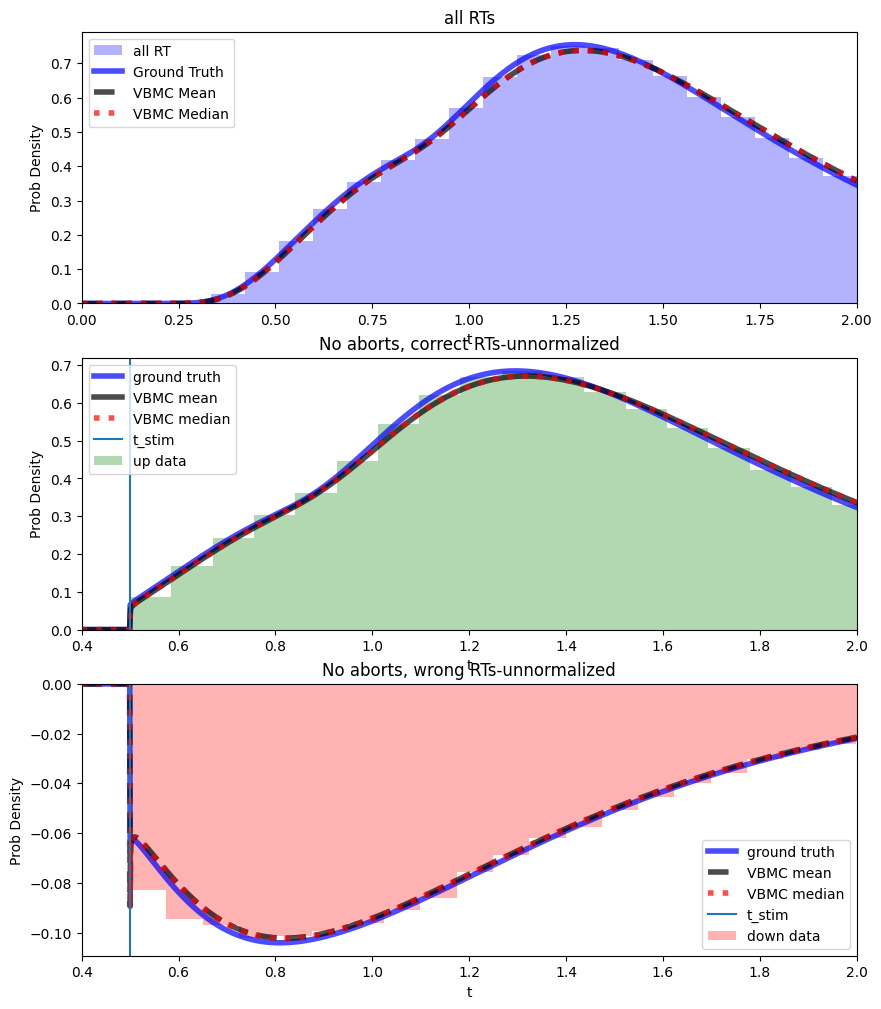

In [28]:
xlim1 = 0.4; xlim2 = 2

plt.figure(figsize=(10, 12))
plt.subplot(3,1,1)
plt.hist(RTs, bins=100, alpha=0.3, label='all RT', density=True, color='b');
plt.plot(t_pts, all_RTs_ground_truth_curve, label='Ground Truth', color='b', alpha=0.7, linewidth=4)
plt.plot(t_pts, all_RTs_mean_curve, label='VBMC Mean', linestyle='--', color='k', alpha=0.7, linewidth=4)
plt.plot(t_pts, all_RTs_median_curve, label='VBMC Median', linestyle=':', color='r', alpha=0.7, linewidth=4)
plt.legend();
plt.xlim(0, xlim2)
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('all RTs');

plt.subplot(3,1,2)
plt.bar(bin_centers_up, hist_up, width=np.diff(bin_edges_up),label='up data', alpha=0.3, color='g');
plt.plot(t_pts, up_RTs_ground_truth_curve, label='ground truth', color='b', alpha=0.7, linewidth=4);
plt.plot(t_pts, up_RTs_mean_curve, label='VBMC mean', linestyle='-', color='k', alpha=0.7, linewidth=4);
plt.plot(t_pts, up_RTs_median_curve, label='VBMC median', linestyle=':', color='r', alpha=0.7, linewidth=4);
plt.xlim(xlim1, xlim2)
plt.axvline(x=t_stim, label='t_stim')
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('No aborts, correct RTs-unnormalized');

plt.subplot(3,1,3)
plt.bar(bin_centers_down, -hist_down, width=np.diff(bin_edges_down),label='down data', alpha=0.3, color='r');
plt.plot(t_pts, -down_RTs_ground_truth_curve, label='ground truth', color='b', alpha=0.7, linewidth=4);
plt.plot(t_pts, -down_RTs_mean_curve, label='VBMC mean', linestyle='--', color='k', alpha=0.7, linewidth=4);
plt.plot(t_pts, -down_RTs_median_curve, label='VBMC median', linestyle=':', color='r', alpha=0.7, linewidth=4);
plt.axvline(x=t_stim, label='t_stim')
plt.xlim(xlim1, xlim2)
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('No aborts, wrong RTs-unnormalized');

# tachometric curve

In [45]:
ground_truth_taco = up_RTs_ground_truth_curve/(up_RTs_ground_truth_curve + down_RTs_ground_truth_curve)

vbmc_mean_taco = up_RTs_mean_curve/(up_RTs_mean_curve + down_RTs_mean_curve)

vbmc_median_taco = up_RTs_median_curve/(up_RTs_median_curve + down_RTs_median_curve)

/tmp/ipykernel_201831/2707037135.py:1: RuntimeWarning: invalid value encountered in divide
  ground_truth_taco = up_RTs_ground_truth_curve/(up_RTs_ground_truth_curve + down_RTs_ground_truth_curve)
/tmp/ipykernel_201831/2707037135.py:3: RuntimeWarning: invalid value encountered in divide
  vbmc_mean_taco = up_RTs_mean_curve/(up_RTs_mean_curve + down_RTs_mean_curve)
/tmp/ipykernel_201831/2707037135.py:5: RuntimeWarning: invalid value encountered in divide
  vbmc_median_taco = up_RTs_median_curve/(up_RTs_median_curve + down_RTs_median_curve)


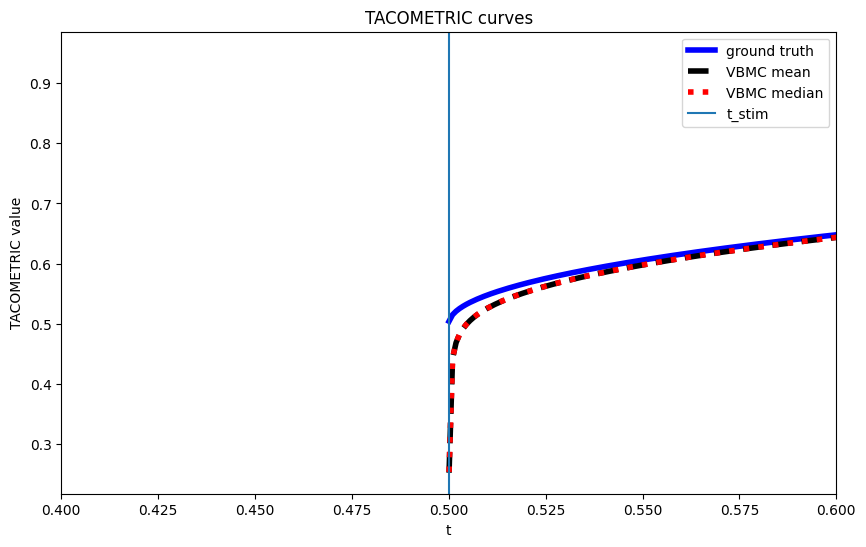

In [52]:
# correct pdf/ correct pdf + wrong pdf
plt.figure(figsize=(10, 6))
plt.plot(t_pts, ground_truth_taco, label='ground truth', color='b', linewidth=4)
plt.plot(t_pts, vbmc_mean_taco, label='VBMC mean', color='k', linestyle='--', linewidth=4)
plt.plot(t_pts, vbmc_median_taco, label='VBMC median', color='r', linestyle=':', linewidth=4)
plt.axvline(x=t_stim, label='t_stim')
plt.xlim(0.4, 0.6)
plt.legend()
plt.title('TACOMETRIC curves')
plt.xlabel('t'); plt.ylabel('TACOMETRIC value');